In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import os

# 2. Load and preprocess data
df = pd.read_csv("data/creditcard.csv")

# Scale 'Amount'
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time'], axis=1)

# Split: Use only legitimate for training
legit = df[df.Class == 0]
fraud = df[df.Class == 1]

X_train, X_val = train_test_split(legit.drop('Class', axis=1), test_size=0.2, random_state=42)

# For test set: mix of legitimate and fraud
test_data = pd.concat([X_val, fraud.drop('Class', axis=1)])
test_labels = np.concatenate([np.zeros(len(X_val)), np.ones(len(fraud))])


In [22]:
input_dim = X_train.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, kernel_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = LeakyReLU()(encoded)
encoded = Dropout(0.2)(encoded)

encoded = Dense(encoding_dim)(encoded)
encoded = LeakyReLU()(encoded)

encoded = Dense(int(encoding_dim/2))(encoded)
encoded = LeakyReLU()(encoded)

# Decoder
decoded = Dense(int(encoding_dim/2))(encoded)
decoded = LeakyReLU()(decoded)

decoded = Dense(input_dim, activation='relu')(decoded)

# Compile model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 29)             │           957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,189 (63.24 KB)

 Trainable params: 16,189 (63.24 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=25,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=1
)


Epoch 1/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.6837 - val_loss: 0.5930
Epoch 2/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.5916 - val_loss: 0.5896
Epoch 3/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.5860 - val_loss: 0.5858
Epoch 4/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.6018 - val_loss: 0.5809
Epoch 5/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.5893 - val_loss: 0.5807
Epoch 6/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.5850 - val_loss: 0.5900
Epoch 7/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.5901 - val_loss: 0.5848
Epoch 8/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.5829 - val_loss: 0.5809
Epoch 9/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.5686 - val_loss: 0.5800
Epoch 10/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.5872 - val_loss: 0.5776
Epoch 11/25
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.5794 - val_loss: 0.5813
Epoch 12/25
7108/71

In [24]:
# Reconstruction error
reconstructions = autoencoder.predict(test_data)
mse = np.mean(np.square(test_data - reconstructions), axis=1)

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, mse)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best F1 Threshold: {best_threshold:.4f}")




1793/1793 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Best F1 Threshold: 7.2064


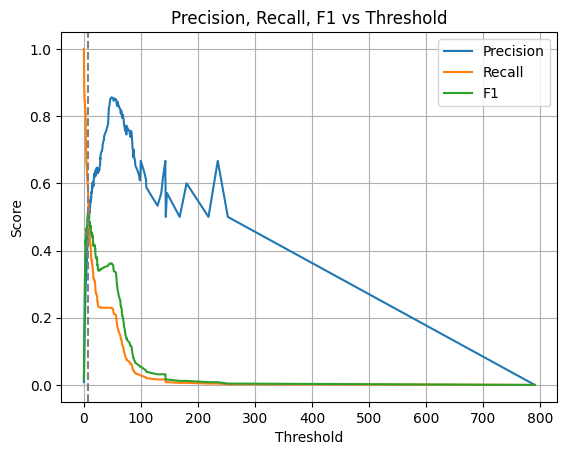

In [25]:
# Ensure matched dimensions when plotting against thresholds
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1')  # <--- FIXED

plt.axvline(x=best_threshold, color='gray', linestyle='--')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.grid(True)
plt.show()


In [26]:
print(best_threshold)

7.206430246967328


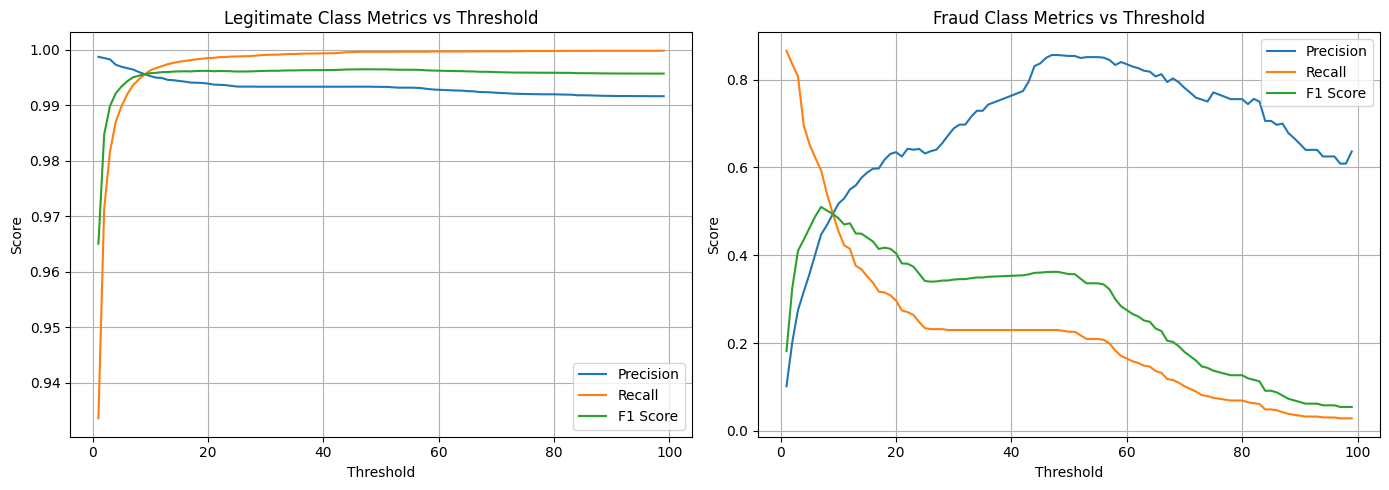

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Lists to collect metrics for each class
thresholds = list(range(1, 100))

# Index 0: Legitimate | Index 1: Fraud
precision_legit, recall_legit, f1_legit = [], [], []
precision_fraud, recall_fraud, f1_fraud = [], [], []

for i in thresholds:
    final_preds = (mse > i).astype(int)
    report = classification_report(
        test_labels, final_preds, target_names=['Legitimate', 'Fraud'], output_dict=True, digits=2
    )

    precision_legit.append(report['Legitimate']['precision'])
    recall_legit.append(report['Legitimate']['recall'])
    f1_legit.append(report['Legitimate']['f1-score'])

    precision_fraud.append(report['Fraud']['precision'])
    recall_fraud.append(report['Fraud']['recall'])
    f1_fraud.append(report['Fraud']['f1-score'])

# ---------------------------
# 📊 Plot for Legitimate
# ---------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, precision_legit, label='Precision')
plt.plot(thresholds, recall_legit, label='Recall')
plt.plot(thresholds, f1_legit, label='F1 Score')
plt.title("Legitimate Class Metrics vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

# ---------------------------
# 📊 Plot for Fraud
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(thresholds, precision_fraud, label='Precision')
plt.plot(thresholds, recall_fraud, label='Recall')
plt.plot(thresholds, f1_fraud, label='F1 Score')
plt.title("Fraud Class Metrics vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import classification_report

thresholds = np.linspace(min(mse), max(mse), 100)
best_threshold = 0
best_f1 = 0
best_recall = 0

# Store for visualization
f1_fraud_list = []
recall_fraud_list = []
precision_fraud_list = []

for threshold in thresholds:
    preds = (mse > threshold).astype(int)
    report = classification_report(test_labels, preds, target_names=['Legitimate', 'Fraud'], output_dict=True)

    f1_fraud = report['Fraud']['f1-score']
    recall_fraud = report['Fraud']['recall']
    precision_fraud = report['Fraud']['precision']

    f1_fraud_list.append(f1_fraud)
    recall_fraud_list.append(recall_fraud)
    precision_fraud_list.append(precision_fraud)

    # Update best threshold for F1
    if f1_fraud > best_f1:
        best_f1 = f1_fraud
        best_threshold = threshold
        best_recall = recall_fraud


C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

In [29]:
print(f"✅ Best Threshold (by F1 Fraud) = {best_threshold:.4f}")
print(f"F1 Score (Fraud): {best_f1:.4f}")
print(f"Recall (Fraud): {best_recall:.4f}")

✅ Best Threshold (by F1 Fraud) = 8.0051
F1 Score (Fraud): 0.5019
Recall (Fraud): 0.5407


C:\Users\aryan\AppData\Local\Temp\ipykernel_27836\1267675364.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


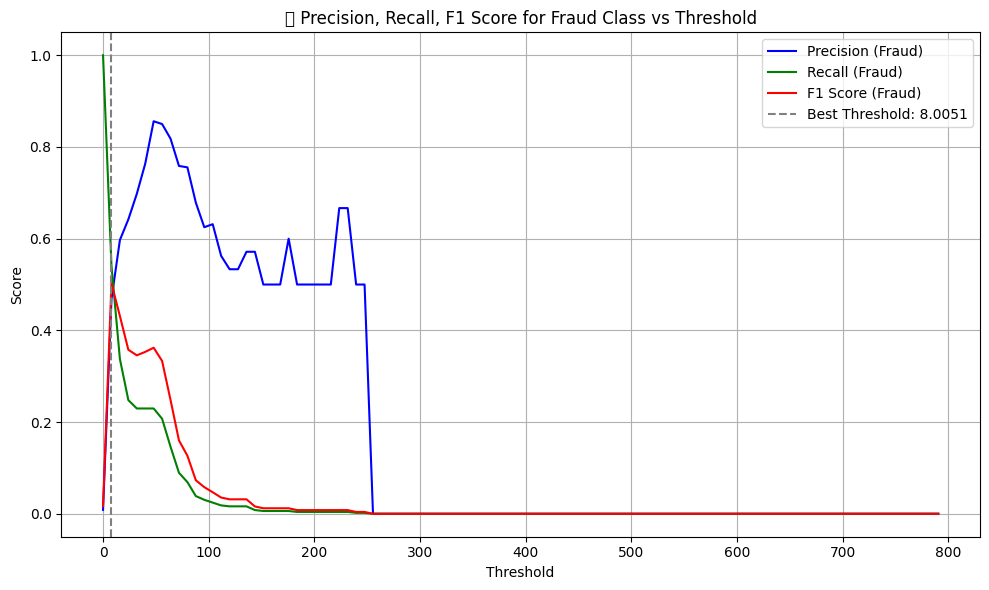

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_fraud_list, label='Precision (Fraud)', color='blue')
plt.plot(thresholds, recall_fraud_list, label='Recall (Fraud)', color='green')
plt.plot(thresholds, f1_fraud_list, label='F1 Score (Fraud)', color='red')
plt.axvline(best_threshold, linestyle='--', color='gray', label=f'Best Threshold: {best_threshold:.4f}')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("📊 Precision, Recall, F1 Score for Fraud Class vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
